In [1]:
import tensorflow as tf
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
import os

In [23]:
BATCH_SIZE = 64
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM=50
EPOCHS = 20

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\VAE\dataset\img_align_celeba\img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

<>:2: SyntaxWarning: invalid escape sequence '\V'
<>:2: SyntaxWarning: invalid escape sequence '\V'
C:\Users\prave\AppData\Local\Temp\ipykernel_26552\2237517880.py:2: SyntaxWarning: invalid escape sequence '\V'
  "C:\VAE\dataset\img_align_celeba\img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE


Found 202599 files.


In [25]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [26]:
def preprocess(image):
    return tf.cast(image, tf.float32)/ 127.5 - 1.0

In [27]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [28]:
for d in train_dataset.take(1):
    print(d.shape)


(64, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49679267..1.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4616747].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3000422].


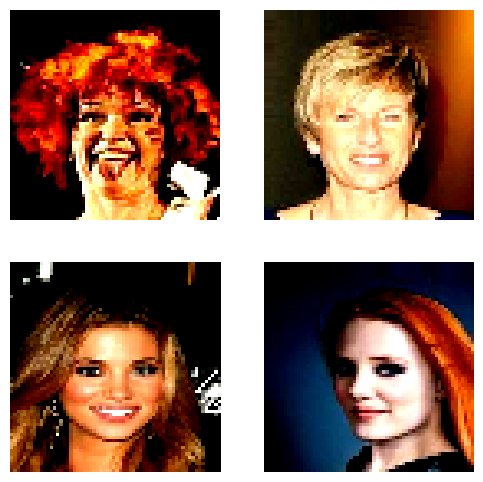

In [29]:
plt.figure(figsize = (6,6))
k = 0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1/2))
    plt.axis('off')
    k+=1

In [30]:
generator = tf.keras.Sequential([
    Input(shape = (LATENT_DIM,)),
    Dense(4*4*LATENT_DIM),
    Reshape((4,4, LATENT_DIM)),

    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4,activation = tf.keras.activations.tanh, strides = 2, padding = 'same'),


], name ='generator')

In [31]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 800)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 256)      │       205,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906,275 (3.46 MB)

 Trainable params: 905,379 (3.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
discriminator = tf.keras.Sequential([
    Input(shape = (IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size=4, strides = 2, padding = 'same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size = 4, strides = 2, padding= 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size = 4, strides = 2, padding= 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),

    Flatten(),
    Dense(1, activation = 'sigmoid')

], name = 'discriminator')

In [33]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 1)        │         4,097 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [34]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim = 100):
        self.latent_dim = latent_dim
        os.makedirs("generated", exist_ok=True)
    
    def on_epoch_end(self, epoch, logs = None):
        n = 6
        k = 0
        out = self.model.generator(tf.random.normal(shape =( 36, self.latent_dim)))
        plt.figure(figsize= (16,16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n,n, k+1)
                plt.imshow((out[k]+1)/2,)
                plt.axis('off')
                k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))


In [35]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name = 'd_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name = 'g_loss')
    @property
    def metrics(self):
        return[self.d_loss_metric, self.g_loss_metric]
 
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        random_noise = tf.random.normal(shape = (batch_size, LATENT_DIM))
        fake_images = self.generator(random_noise)

        real_labels = tf.ones((batch_size, 1))+0.25*tf.random.uniform(shape = (batch_size, 1), minval = -1, maxval = 1)
        fake_labels = tf.zeros((batch_size, 1))+0.25*tf.random.uniform(shape=(batch_size, 1))

        with tf.GradientTape() as recorder:
            real_predictions=self.discriminator(real_images)
            d_loss_real = self.loss_fn(real_labels, real_predictions)

            fake_predictions = self.discriminator(fake_images)
            d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

            d_loss = d_loss_real + d_loss_fake
        
        partial_derivatives = recorder.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))


        random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))
        flipped_fake_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as recorder:
            fake_predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(flipped_fake_labels, fake_predictions)

        partial_derivatives = recorder.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(),
                'g_loss': self.g_loss_metric.result()}

In [36]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

   3165/Unknown 2018s 630ms/step - d_loss: 0.8941 - g_loss: 1.4650

c:\VAE\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 2021s 631ms/step - d_loss: 0.9897 - g_loss: 1.2169


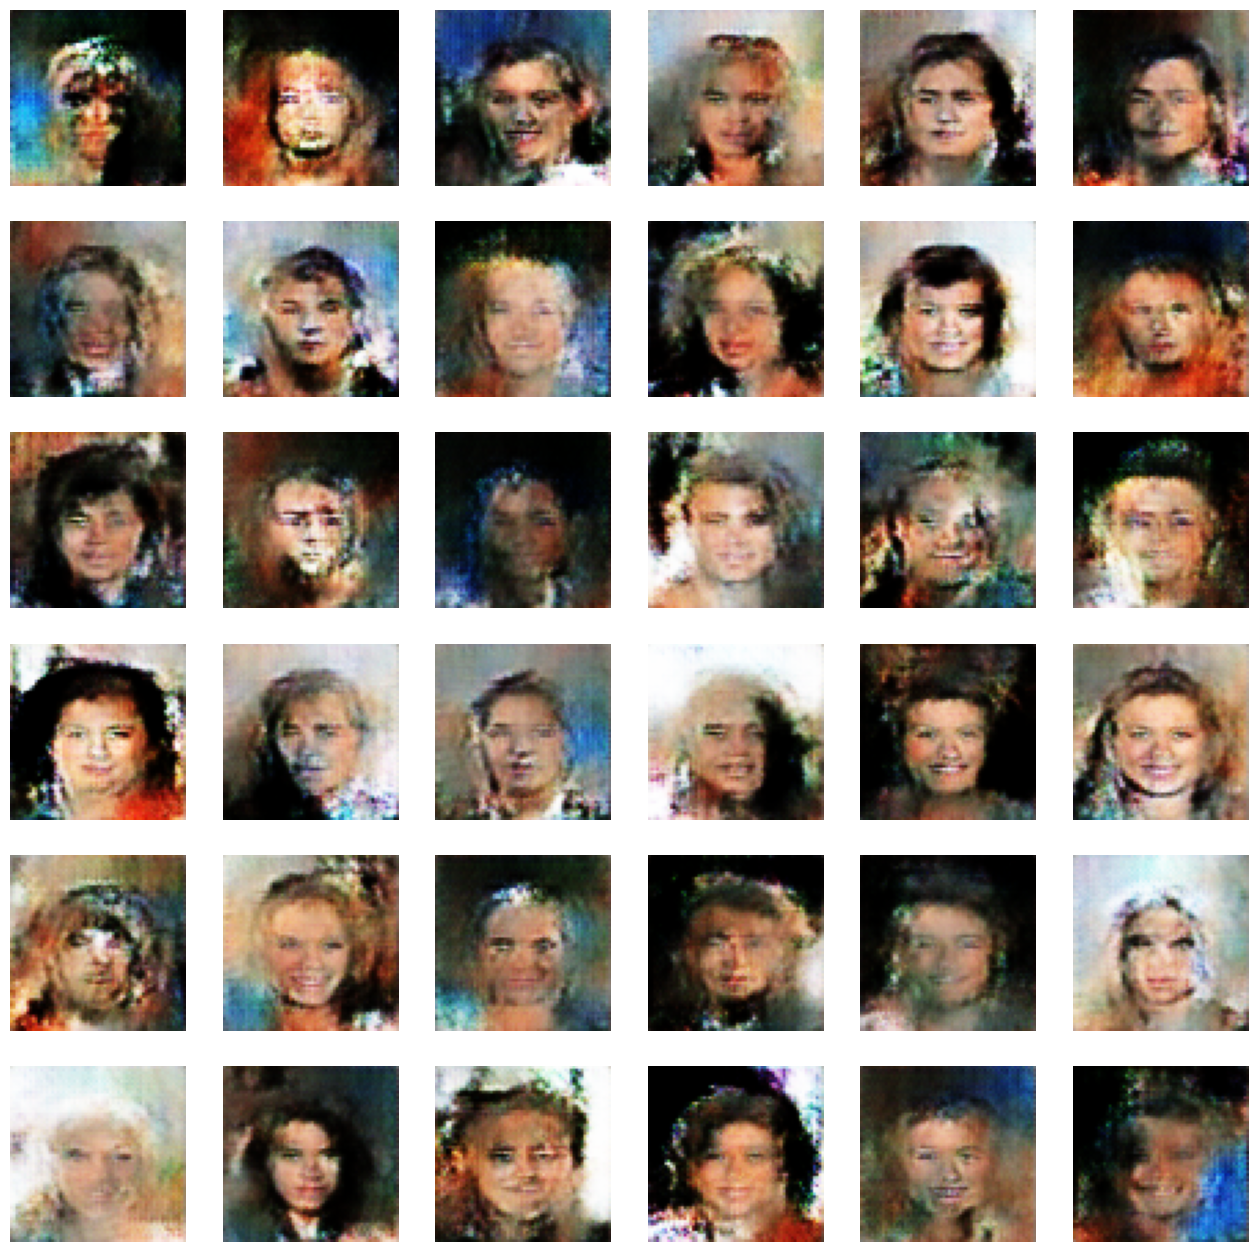

In [37]:
EPOCHS=1
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])